# Exploratory Data Analysis

## Set up

In [1]:
%matplotlib inline

import itertools
import logging
import pickle
import folium
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn import preprocessing
from datetime import datetime, date, timedelta
from palettable.colorbrewer.sequential import Oranges_9

from src.data.visualization import create_london_map, draw_stations_map

sns.set_context("notebook")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
readings = pickle.load(open("data/parsed/readings_weather_filled_dataset.p", "rb"))
stations = pickle.load(open('data/parsed/stations_dataset_final.p', 'rb'))
distributed = pickle.load(open('data/parsed/distributed_dataset_final.p', 'rb'))
collected = pickle.load(open('data/parsed/collected_dataset_final.p', 'rb'))

In [3]:
import time
from pytz import timezone

start_time = time.time()

readings['Timestamp'] = readings.Timestamp.dt.tz_convert(timezone('Europe/London'))
readings['Timestamp'] = readings.Timestamp.dt.tz_localize(None)

end_time = time.time()
print 'Modifying timestamp took %s' % (end_time - start_time)

Modifying timestamp took 0.325202226639


In [4]:
def get_day_start_end(day, hours=None):
    start = day.replace(hour=7, minute=0, second=0, microsecond=0)
    if hours is None:
        return (start, day.replace(hour=23, minute=0, second=0, microsecond=0))
    else:
        return (start, start + timedelta(hours=hours))
    
def get_full_day_range(timestamp):
    return timestamp.replace(hour=0, minute=0, second=0, microsecond=0), timestamp.replace(hour=23, minute=59, second=59, microsecond=999)

def filter_by_time(df, d1, d2):
    timestamp = df['Timestamp']
    selector = (timestamp >= d1) & (timestamp < d2)
    return df[selector]
    
def filter_by_id(df, idval):
    return df[df['Id'] == idval]

global_start = datetime(2016,5,16)
global_end = datetime(2016,6,26)

## Station Priority

In [5]:
def map_priority_color(priority):
    if priority == 1:
        return '#ff1a1a', '#cc0000'
    elif priority == 2:
        return '#3333ff', '#0000cc'
    else: 
        return '#ffff1a', '#b3b300'
    
def create_priority_marker(station):
    colors = map_priority_color(station['Priority'])
    label = "%s - %s" % (station['Id'], station['Name'])

    return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=50,
                        popup=label, color=colors[1], fill_color=colors[0])

priority_map = draw_stations_map(stations, create_priority_marker)

folium.Map.save(priority_map, 'reports/maps/stations_priorities.html')

## Bicycle Availability Readings

### Why are the readings not continuous?

We believe the readings are updated as follows:
* The station publishes its readings only when an change in the station occurred in the last 5 minutes
* This means most of the readings will be different than the previous one
* When this is not the case, we suspect that an equal number of bikes left and arrived to the station, leaving the station in the same state as it was before but triggering an update to be published

In [6]:
start, end = get_day_start_end(datetime(2016,5,17))
df = filter_by_time(filter_by_id(readings, 'BikePoints_374'), start, end)[['Timestamp', 'NbBikes']]
df

,Timestamp,NbBikes
3492749,2016-05-17 07:01:23.760000000,23.0
3492750,2016-05-17 07:06:23.760000000,23.0
3492751,2016-05-17 07:11:25.750000128,20.0
3492752,2016-05-17 07:16:25.750000128,20.0
3492753,2016-05-17 07:21:24.247000064,26.0
3492754,2016-05-17 07:26:28.020000000,31.0
3492755,2016-05-17 07:31:28.167000064,26.0
3492756,2016-05-17 07:36:28.167000064,26.0
3492757,2016-05-17 07:41:28.167000064,26.0
3492758,2016-05-17 07:46:31.467000064,33.0


### High vs Low Priority

In [7]:
def plot_station_readings(readings, station_id, ycols1, ycols2, d1, d2):
    date_range = pd.date_range(d1, d2, freq='d')
    date_pairs = [[date_range[i], date_range[i+1]] for i in range(len(date_range)-1)]

    station_readings = filter_by_id(readings, station_id)
    slices = slice_by(station_readings, 'Timestamp', date_pairs)  
    
    # set plot properties
    ncols = 7
    nrows = int(len(slices) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)  
    fig.suptitle('Bikes Available in %s' % (station_id))
    fig.set_size_inches(18.5, 10.5)
    fig.text(0.1, 0.5, 'Number of Bikes', va='center', rotation='vertical')
        
    plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols)

def slice_by(df, col_name, date_pairs):
    groups = []
    for pair in date_pairs:
        groups.append(filter_by_time(df, pair[0], pair[1]))
    return groups

def plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols):
    i = 0    
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row,col]
                        
            # x axis set up            
            day_start, day_end = get_day_start_end(slices[i].iloc[0]['Timestamp'])
            xticks = pd.date_range(start=day_start,end=day_end, freq='2h')
            xlim = (day_start, day_end)

            # y axis set up
            ylim = (0, max(slices[i]['NbDocks']) + 5)
                        
            # set up data
            cols = ycols1 + ycols2
            cols.append('Timestamp')
            df = slices[i][cols]
                        
            # plot the entry                        
            sub_ax = df.plot(x='Timestamp', ax=ax, xticks=xticks,
                           legend=False, sharex=True, sharey=True,
                           xlim=xlim, ylim=ylim, secondary_y=ycols2)
                        
            sub_ax.set_xlabel(calendar.day_name[col])
            sub_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            i+=1        

In [8]:
def plot_timeline(df, station_id, start, end):
    df = filter_by_time(filter_by_id(df, station_id), start, end)[['Timestamp']]

    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    ax = sns.stripplot(data=df, x='Timestamp', y='Day', orient='h');
    ax.set_xlim(get_day_start_end(df['Timestamp'].iloc[0]))
    ax.set_title('Readings of Station %s' % (station_id))
    
    return ax

In [9]:
ycols1 = ['NbBikes', 'NbUnusableDocks']
ycols2 = ['Temp']
start = datetime(2016,5,16)
end = datetime(2016,5,30)

### High Priority Stations

**Belgrove Street , King's Cross** City Center

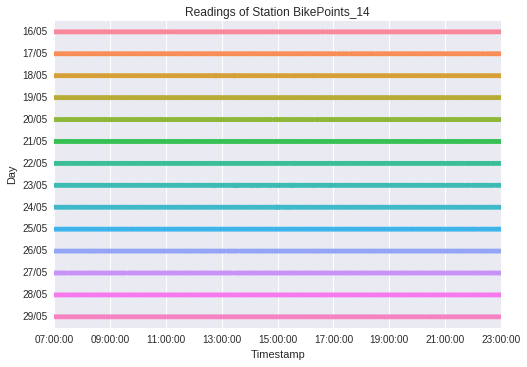

In [10]:
station_id = 'BikePoints_14'
plot_timeline(readings, station_id, start, end)

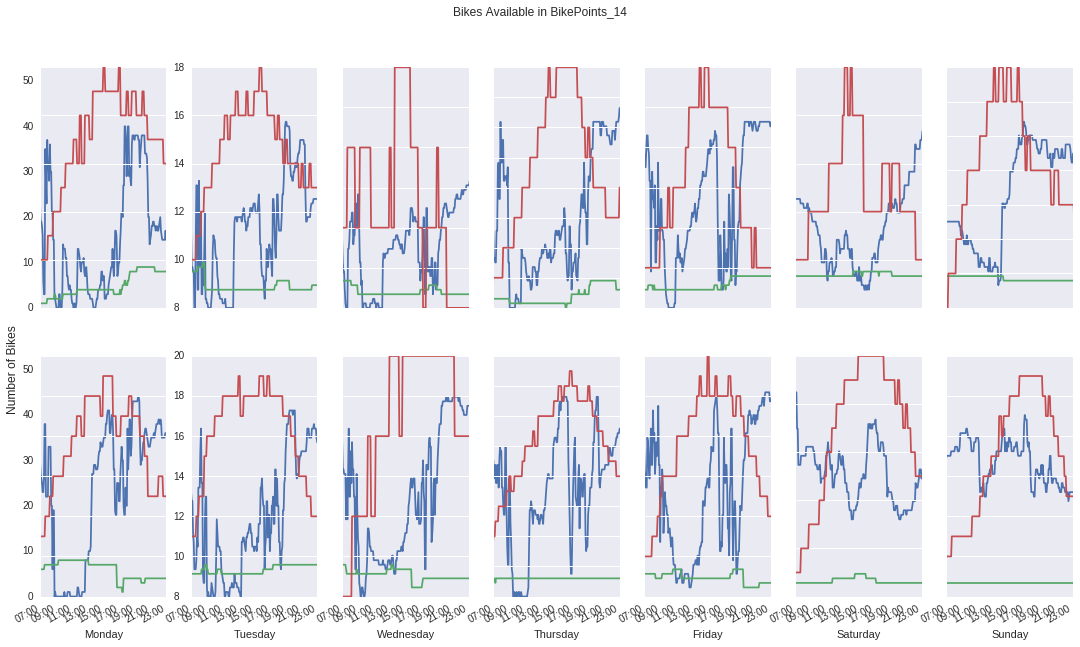

In [11]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

**Regent's Row , Haggerston ** Outside City Center

In [12]:
station_id = 'BikePoints_553'

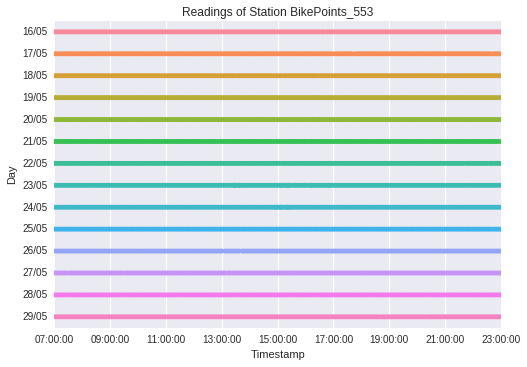

In [13]:
plot_timeline(readings, station_id, start, end)

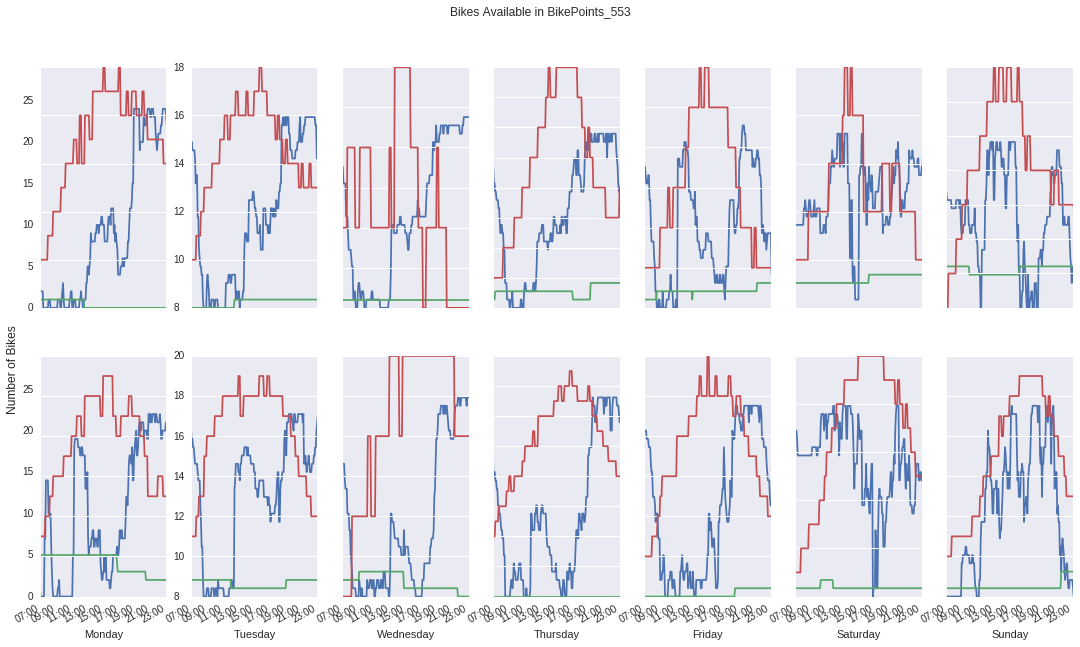

In [14]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

### Low Priority Stations
**Sackville Street, Mayfair** City Center

In [15]:
station_id = 'BikePoints_318'

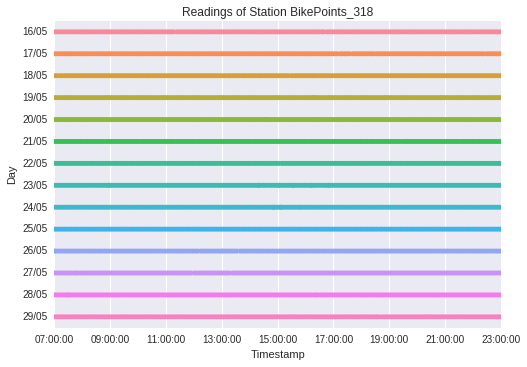

In [16]:
plot_timeline(readings, station_id, start, end)

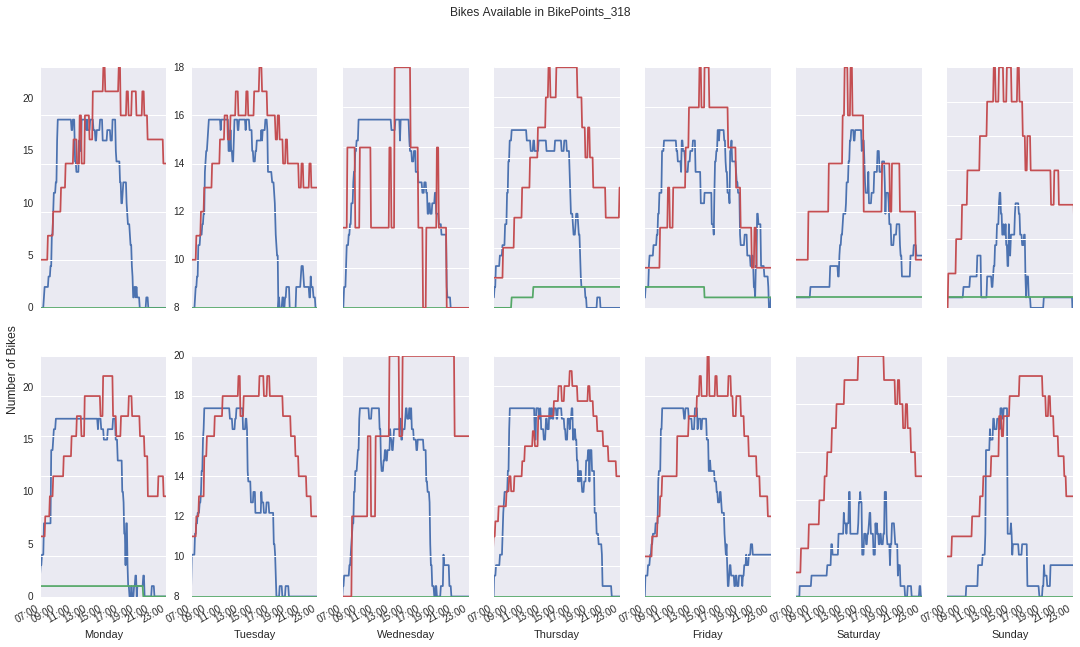

In [17]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

**St. Mark's Road, North Kensington** Outside City Center

In [18]:
station_id = 'BikePoints_650'

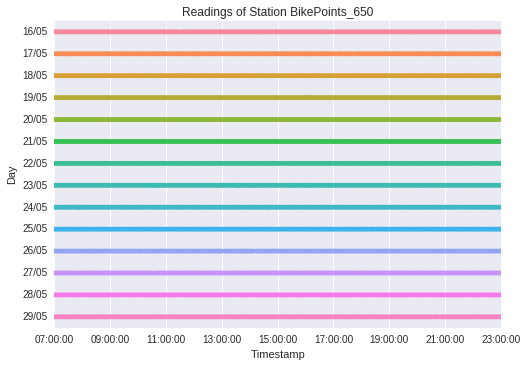

In [19]:
plot_timeline(readings, station_id, start, end)

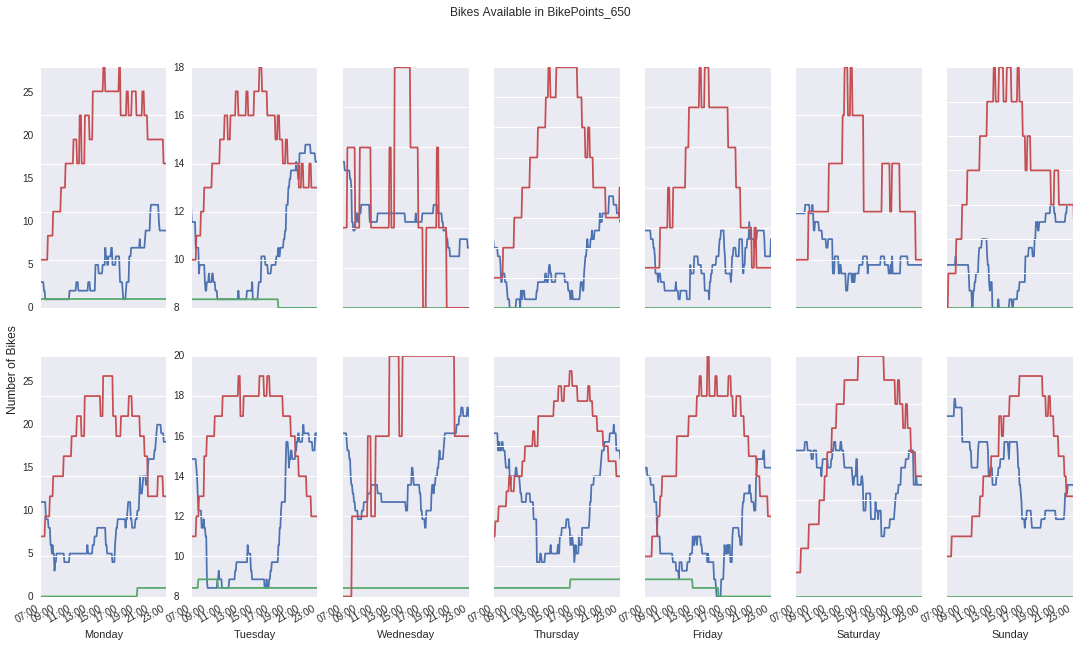

In [20]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

In [21]:
stations.sort_values(by=['Name']).to_csv('stations.csv')

## Bicycle Redistribution

In [22]:
# merge with the stations dataset
stations_redistribution = stations.merge(distributed.groupby('Id').sum(), left_on='Id', how='left', right_index=True)
stations_redistribution.rename(columns = {'NbBikes':'NbBikesDist'}, inplace = True)
stations_redistribution = stations_redistribution.merge(collected.groupby('Id').sum(), left_on='Id', how='left', right_index=True)
stations_redistribution.rename(columns = {'NbBikes':'NbBikesColl'}, inplace = True)
stations_redistribution.drop(['TerminalName','PlaceType','Installed','Temporary','Locked','RemovalDate','InstallDate','ShortName'], axis=1, inplace=True)

# fill missing values with 0
stations_redistribution['NbBikesDist'].fillna(0, inplace=True)
stations_redistribution['NbBikesColl'].fillna(0, inplace=True)

# scale to use easily the colormap
min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
stations_redistribution['NbBikesDistS'] = min_max_scaler.fit_transform(stations_redistribution['NbBikesDist'].values.reshape(-1, 1))
stations_redistribution['NbBikesCollS'] = min_max_scaler.fit_transform(stations_redistribution['NbBikesColl'].values.reshape(-1, 1))

In [23]:
def cmap_to_hex(cmap, value):
    rgb = cmap(value)[:3]
    return clrs.rgb2hex(rgb)

def create_redistribution_marker(col_name):
    def create_marker(station):
        line_color = map_priority_color(station['Priority'])[1]
        fill_color = cmap_to_hex(Oranges_9.mpl_colormap, station[col_name])
    
        label = "%s - %s" % (station['Id'], station['Name'])

        return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=100,
                        popup=label, color=line_color, fill_color=fill_color, fill_opacity=0.9)
    
    return create_marker

In [24]:
def plot_redistribution_grid(df, start, end, ids=None):
    df = df[df['Id'].isin(ids)]
    df = filter_by_time(df, start, end).copy()
    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    
    day_start, day_end = get_day_start_end(df.iloc[0]['Timestamp'])
    g = sns.FacetGrid(df, col="Id", col_wrap=4, size=3, xlim=(day_start, day_end), sharex=True, sharey=True, col_order=ids)
    [ax.xaxis_date() for ax in g.axes]
    [ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) for ax in g.axes]
    g = g.map(sns.stripplot, "Timestamp", "Day", "Day", orient='h', palette="hls")
    g = g.set(xticks=pd.date_range(start=day_start,end=day_end, freq='6h'))
    
    return g

### Distributed

In [25]:
top_distributed = stations_redistribution.sort_values(by=['NbBikesDist'], ascending=False)
top_distributed.set_index('Id', inplace=True)
top_distributed[0:20]

,Name,Latitude,Longitude,Priority,NbBikesDist,NbBikesColl,NbBikesDistS,NbBikesCollS
Id,,,,,,,,
BikePoints_374,"Waterloo Station 1, Waterloo",51.504027,-0.113864,1,13720.0,11324.0,1.000000,1.000000
BikePoints_361,"Waterloo Station 2, Waterloo",51.503919,-0.113426,1,11542.0,7939.0,0.841254,0.701077
BikePoints_20,"Drummond Street, Euston",51.527736,-0.135273,2,4246.0,2330.0,0.309475,0.205758
BikePoints_574,"Eagle Wharf Road, Hoxton",51.533560,-0.093150,2,3848.0,211.0,0.280466,0.018633
BikePoints_154,"Waterloo Station 3, Waterloo",51.503791,-0.112824,1,3778.0,2568.0,0.275364,0.226775
BikePoints_436,"Red Lion Street, Holborn",51.518240,-0.116550,1,3291.0,2857.0,0.239869,0.252296
BikePoints_25,"Doric Way, Somers Town",51.528833,-0.132250,2,3216.0,1780.0,0.234402,0.157188
BikePoints_45,"Boston Place, Marylebone",51.522511,-0.162298,2,3041.0,1433.0,0.221647,0.126545
BikePoints_427,"Cheapside, Bank",51.513970,-0.092940,1,3020.0,3263.0,0.220117,0.288149


In [26]:
draw_stations_map(top_distributed, create_redistribution_marker('NbBikesDistS'))

KeyError: 'Id'

In [ ]:
plot_redistribution_grid(distributed, datetime(2016,5,16), datetime(2016,6,26), ids=top_distributed['Id'])

### Collected

In [27]:
top_collected = stations_redistribution.sort_values(by=['NbBikesColl'], ascending=False)
top_collected.set_index('Id', inplace=True)
top_collected[0:20]

,Name,Latitude,Longitude,Priority,NbBikesDist,NbBikesColl,NbBikesDistS,NbBikesCollS
Id,,,,,,,,
BikePoints_374,"Waterloo Station 1, Waterloo",51.504027,-0.113864,1,13720.0,11324.0,1.000000,1.000000
BikePoints_194,"Hop Exchange, The Borough",51.504627,-0.091773,1,83.0,8859.0,0.006050,0.782321
BikePoints_361,"Waterloo Station 2, Waterloo",51.503919,-0.113426,1,11542.0,7939.0,0.841254,0.701077
BikePoints_228,"St. Jamess Square, St. Jamess",51.507424,-0.134621,1,1081.0,5495.0,0.078790,0.485253
BikePoints_251,"Brushfield Street, Liverpool Street",51.518908,-0.079249,1,883.0,4760.0,0.064359,0.420346
BikePoints_64,"William Iv Street, Strand",51.509462,-0.124749,1,219.0,4634.0,0.015962,0.409219
BikePoints_278,"Tooley Street, Bermondsey",51.503493,-0.079620,1,223.0,4136.0,0.016254,0.365242
BikePoints_108,"Abbey Orchard Street, Westminster",51.498125,-0.132102,1,2253.0,3975.0,0.164213,0.351024
BikePoints_66,"Holborn Circus, Holborn",51.517950,-0.108657,1,2082.0,3974.0,0.151749,0.350936


In [ ]:
draw_stations_map(top_collected, create_redistribution_marker('NbBikesCollS'))

In [ ]:
plot_redistribution_grid(collected, datetime(2016,5,16), datetime(2016,6,26), ids=top_collected['Id'])

### Clusters

In [28]:
%run src/data/periods.py

In [29]:
%run src/data/helper.py

In [30]:
readings2 = readings[readings.Source == 'REAL']
readings2 = readings2.sort_values(by=['Id', 'Timestamp'], ascending=True)

In [31]:
empty_entries = find_zero_periods(readings2, 'NbBikes')
empty_groups = get_ellapsed_time(empty_entries, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)
full_entries = find_zero_periods(readings2, 'NbEmptyDocks')
full_groups = get_ellapsed_time(full_entries, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)

In [32]:
empty_all = empty_groups.groupby('Id').sum()
empty_all.columns=['EmptyTotalAll']

full_all = full_groups.groupby('Id').sum()
full_all.columns=['FullTotalAll']

In [33]:
invalid_threshold = 720
invalid_group_ids = empty_groups[empty_groups.Ellapsed >= invalid_threshold].GroupId
empty_entries = empty_entries[~empty_entries.GroupId.isin(invalid_group_ids)]
invalid_group_ids = full_groups[full_groups.Ellapsed >= invalid_threshold].GroupId
full_entries = full_entries[~full_entries.GroupId.isin(invalid_group_ids)]

In [34]:
empty_periods = get_ellapsed_time(empty_entries, by='PeriodId')
empty_periods = add_station_info(empty_periods, stations, ['Priority', 'Id'])
empty_periods['Day'] = empty_periods['Period'].apply(lambda x: get_period_day(x))
empty_periods['PeakHours'] = empty_periods['Period'].apply(lambda x: is_peaktime(x)[1])

full_periods = get_ellapsed_time(full_entries, by='PeriodId')
full_periods = add_station_info(full_periods, stations, ['Priority', 'Id'])
full_periods['Day'] = full_periods['Period'].apply(lambda x: get_period_day(x))
full_periods['PeakHours'] = full_periods['Period'].apply(lambda x: is_peaktime(x)[1])

In [35]:
empty_periods_df = empty_periods.groupby(['Id', 'PeakHours']).sum().unstack()
empty_periods_df.columns = empty_periods_df.columns.droplevel()
empty_periods_df.columns.name = None
empty_periods_df.columns = ['EmptyEveningPeak', 'EmptyMorningPeak', 'EmptyNonPeak']
empty_periods_df['EmptyTotal'] = empty_periods_df.EmptyEveningPeak + empty_periods_df.EmptyMorningPeak + empty_periods_df.EmptyNonPeak

In [36]:
full_periods_df = full_periods.groupby(['Id', 'PeakHours']).sum().unstack()
full_periods_df.columns = full_periods_df.columns.droplevel()
full_periods_df.columns.name = None
full_periods_df.columns = ['FullEveningPeak', 'FullMorningPeak', 'FullNonPeak']
full_periods_df['FullTotal'] = full_periods_df.FullEveningPeak + full_periods_df.FullMorningPeak + full_periods_df.FullNonPeak

In [37]:
periods = empty_periods_df.merge(full_periods_df, right_index=True, left_index=True)

In [45]:
readings2['WeightedNbBikesStd'] = readings.NbBikes / readings.NbDocks
weighted_std = readings2.groupby('Id').std()

In [49]:
stats = readings2.groupby('Id').agg({'Timestamp': 'count', 'NbDocks': 'max'})
stats.columns = ['Count', 'NbDocks']

stats = stats.merge(periods, how='left', right_index=True, left_index=True).fillna(0)
stats = stats.merge(top_collected[['NbBikesColl']], how='left', right_index=True, left_index=True).fillna(0)
stats = stats.merge(top_distributed[['NbBikesDist']], how='left', right_index=True, left_index=True).fillna(0)
stats = stats.merge(weighted_std[['WeightedNbBikes']], how='left', right_index=True, left_index=True).fillna(0)

stats = add_station_info(stats, stations.set_index(stations.Id), use_indexes=True).drop(['Id', 'Name'], axis=1)
stats.Priority = stats.Priority.fillna(3).astype('int8')
stats

,Count,NbDocks,EmptyEveningPeak,EmptyMorningPeak,EmptyNonPeak,EmptyTotal,FullEveningPeak,FullMorningPeak,FullNonPeak,FullTotal,NbBikesColl,NbBikesDist,WeightedNbBikes,Latitude,Longitude,Priority
Id,,,,,,,,,,,,,,,,
BikePoints_1,1348,19.0,716.0,1289.0,3600.0,5605.0,118.0,5.0,977.0,1100.0,9.0,1121.0,0.249440,51.529163,-0.109970,2
BikePoints_10,1750,18.0,455.0,457.0,4055.0,4967.0,167.0,0.0,797.0,0.0,341.0,125.0,0.276474,51.505974,-0.092754,2
BikePoints_100,1956,24.0,290.0,36.0,910.0,1236.0,26.0,437.0,645.0,1108.0,257.0,450.0,0.240004,51.490435,-0.122806,2
BikePoints_101,3244,22.0,788.0,878.0,15559.0,17225.0,183.0,890.0,1035.0,2108.0,0.0,0.0,0.296015,51.511553,-0.092940,1
BikePoints_102,1712,17.0,1761.0,897.0,16005.0,18663.0,270.0,729.0,3105.0,4104.0,351.0,150.0,0.334019,51.513406,-0.076793,2
BikePoints_103,1340,18.0,753.0,1721.0,4788.0,7262.0,5.0,135.0,105.0,245.0,26.0,516.0,0.237761,51.504723,-0.192538,2
BikePoints_104,3014,34.0,155.0,1119.0,4281.0,5555.0,273.0,66.0,732.0,1071.0,2119.0,201.0,0.290370,51.511594,-0.077121,1
BikePoints_105,2168,26.0,694.0,166.0,1535.0,2395.0,17.0,440.0,3265.0,3722.0,78.0,340.0,0.273838,51.515529,-0.190240,2
BikePoints_106,1510,21.0,751.0,2028.0,19186.0,21965.0,130.0,21.0,1153.0,1304.0,142.0,196.0,0.296680,51.514105,-0.147301,2


In [50]:
pickle.dump(stats, open("data/parsed/stations_statistics.p", "wb"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

empty_pred = KMeans(n_clusters=3).fit_predict(stats[['EmptyEveningPeak', 'EmptyMorningPeak', 'EmptyNonPeak']].values)
full_pred = KMeans(n_clusters=3).fit_predict(stats[['FullEveningPeak', 'FullMorningPeak', 'FullNonPeak']].values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.5))

###############################################################################
# Empty Minutes Clusters

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_title('Empty Minutes Clusters')
ax.set_xlabel('EmptyEveningPeak')
ax.set_ylabel('EmptyMorningPeak')
ax.set_zlabel('EmptyNonPeak')

ax.set_xlim(0, max(stats.EmptyEveningPeak))
ax.set_ylim(0, max(stats.EmptyMorningPeak))
ax.set_zlim(0, max(stats.EmptyNonPeak))

ax.view_init(elev=30, azim=230)
ax.dist=12                  

ax.scatter(stats.EmptyEveningPeak, stats.EmptyMorningPeak, stats.EmptyNonPeak,
           c=empty_pred, color='red', marker='o', s=30)

###############################################################################
# Full Minutes Clusters

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_title('Full Minutes Clusters')
ax.set_xlabel('FullEveningPeak')
ax.set_ylabel('FullMorningPeak')
ax.set_zlabel('FullNonPeak')

ax.set_xlim(0, max(stats.FullEveningPeak))
ax.set_ylim(0, max(stats.FullMorningPeak))
ax.set_zlim(0, max(stats.FullNonPeak))

ax.view_init(elev=30, azim=230)
ax.dist=12                  

ax.scatter(stats.FullEveningPeak, stats.FullMorningPeak, stats.FullNonPeak,
           c=full_pred, color='blue', marker='o', s=30)

plt.show()

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.scatter(stats.Count, stats.NbDocks, c=stats.Priority)
plt.title("Incorrect Number of Blobs")

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

###############################################################################
# Generate sample data
X = stats[['Count', 'NbDocks']].values

###############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

###############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
chido = stats.copy()
chido['EmptyCluster'] = empty_pred
chido['FullCluster'] = full_pred
chido['ActivityCluster'] = ms.labels_

In [ ]:
chido